In [ ]:
# cài bộ thư viện d2l
!pip install d2l==0.16.5


# Densely Connected Networks (DenseNet)

ResNet đã làm thay đổi đáng kể quan điểm về cách tham số hóa các hàm số trong mạng nơ-ron sâu. Ở một mức độ nào đó, DenseNet có thể được coi là phiên bản mở rộng hợp lý của ResNet. Để hiểu cách đi đến kết luận đó, ta cần tìm hiểu một chút lý thuyết.



## From ResNet to DenseNet

Nhắc lại công thức khai triển Taylor cho hàm một biến vô hướng như sau:

$$f(x) = f(0) + f'(0) x + \frac{f''(0)}{2!}  x^2 + \frac{f'''(0)}{3!}  x^3 + \ldots.$$

Điểm mấu chốt là khai triển Taylor phân tách hàm số thành các số hạng có bậc tăng dần. Tương tự, ResNet phân tách các hàm số thành:

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

Cụ thể, ResNet tách hàm số   $f$ thành một số hạng tuyến tính đơn giản và một số hạng phi tuyến phức tạp hơn. Nếu ta muốn tách ra thành nhiều hơn hai số hạng thì sao? .
Một giải pháp đã được đề xuất bởi trong bài báo [Huang et al., 2017] với kiến trúc DenseNet. Kiến trúc này đạt được kết quả kỉ lục trên tập dữ liệu ImageNet.

![The main difference between ResNet (left) and DenseNet (right) in cross-layer connections: use of addition and use of concatenation. ](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/img/densenet-block.svg?raw=1)
<!-- :label:`fig_densenet_block` -->

Điểm khác biệt chính là DenseNet nối đầu ra lại với nhau thay vì cộng lại như ở ResNet. Kết quả là ta thực hiện một ánh xạ từ  x  đến các giá trị của nó sau khi áp dụng một chuỗi các hàm với độ phức tạp tăng dần.

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$

Cuối cùng, tất cả các hàm số này sẽ được kết hợp trong một Perceptron đa tầng để giảm số lượng đặc trưng một lần nữa. Lập trình thay đổi này khá đơn giản — thay vì cộng các số hạng với nhau, ta sẽ nối chúng lại. Cái tên DenseNet phát sinh từ việc đồ thị phụ thuộc giữa các biến trở nên khá dày đặc. Tầng cuối cùng của một chuỗi như vậy được kết nối “dày đặc” tới tất cả các tầng trước đó.

![Dense connections in DenseNet.](http://d2l.ai/_images/densenet.svg)
:label:`fig_densenet`

 Thành phần chính của DenseNet là các khối dày đặc và các tầng chuyển tiếp. Các khối dày đặc định nghĩa cách các đầu vào và đầu ra được nối với nhau, trong khi các tầng chuyển tiếp kiểm soát số lượng kênh sao cho nó không quá lớn. 

## [**Dense Blocks**]

DenseNet sử dụng kiến trúc “chuẩn hóa theo batch, hàm kích hoạt và phép tích chập” đã qua sửa đổi của ResNet. Đầu tiên, ta sẽ lập trình kiến trúc này trong hàm conv_block.


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        # batchnorm
        None
        # relu
        None
        # conv
        None
    )

Một khối dày đặc bao gồm nhiều khối conv_block với cùng số lượng kênh đầu ra. Tuy nhiên, ta sẽ nối đầu vào và đầu ra của từng khối theo chiều kênh khi tính toán lượt truyền xuôi.

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(None):
            layer.append(
                conv_block(num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = None # cat X va Y theo chieu cua channel 
        return X

Trong ví dụ sau, ta sẽ định nghĩa một khối dày đặc gồm hai khối tích chập với 10 kênh đầu ra. Với một đầu vào gồm 3 kênh, ta sẽ nhận được một đầu ra với  3+2×10=23  kênh. Số lượng kênh của khối tích chập kiểm soát sự gia tăng của số lượng kênh đầu ra so với số lượng kênh đầu vào. Số lượng kênh này còn được gọi là tốc độ tăng trưởng (growth rate).

In [ ]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
assert Y.shape == (4,23,8,8)

## [**Transition Layers**]

Mỗi khối dày đặc sẽ làm tăng thêm số lượng kênh. Nhưng việc thêm quá nhiều kênh sẽ tạo nên một mô hình phức tạp quá mức. Do đó, một tầng chuyển tiếp sẽ được sử dụng để kiểm soát độ phức tạp của mô hình. Tầng này dùng một tầng tích chập  1×1  để giảm số lượng kênh, theo sau là một tầng avgpool với sải bước bằng 2 để giảm một nửa chiều cao và chiều rộng, từ đó giảm độ phức tạp của mô hình hơn nữa.

In [ ]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(None), nn.ReLU(),
        nn.Conv2d(None, None, kernel_size=None),
        nn.AvgPool2d(kernel_size=None, stride=None))

Ta sẽ áp dụng một tầng chuyển tiếp với 10 kênh lên đầu ra của khối dày đặc trong ví dụ trước. Việc này sẽ làm giảm số lượng kênh đầu ra xuống còn 10, đồng thời làm giảm đi một nửa chiều cao và chiều rộng.

In [ ]:
blk = transition_block(23, 10)
assert blk(Y).shape == (4,10,4,4)

## [**DenseNet Model**]

Tiếp theo, ta sẽ xây dựng một mô hình DenseNet. Đầu tiên, DenseNet sử dụng một tầng tích chập và một tầng gộp cực đại như trong ResNet.

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Sau đó, tương tự như cách ResNet sử dụng bốn khối phần dư, DenseNet cũng dùng bốn khối dày đặc. Và cũng giống như ResNet, ta có thể tùy chỉnh số lượng tầng tích chập được sử dụng trong mỗi khối dày đặc. Ở đây, ta sẽ đặt số lượng khối tích chập bằng 4 để giống với kiến trúc ResNet-18 trong phần trước. Ngoài ra, ta đặt số lượng kênh (tức tốc độ tăng trưởng) của các tầng tích chập trong khối dày đặc là 32, vì vậy 128 kênh sẽ được thêm vào trong mỗi khối dày đặc.

Trong ResNet, chiều cao và chiều rộng được giảm sau mỗi khối bằng cách sử dụng một khối phần dư với sải bước bằng 2. Ở đây, ta sẽ sử dụng tầng chuyển tiếp để làm giảm đi một nửa chiều cao, chiều rộng và số kênh.

In [ ]:
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

Tương tự như ResNet, một tầng gộp toàn cục và một tầng kết nối đầy đủ sẽ được thêm vào cuối mạng để tính toán đầu ra.

In [ ]:
net = nn.Sequential(b1, *blks, nn.BatchNorm2d(None), nn.ReLU(),
                    nn.AdaptiveMaxPool2d((1, 1)), nn.Flatten(),
                    nn.Linear(None, None))

## [**Training**]

Trong phần này, vì đang sử dụng một mạng sâu hơn nên để đơn giản hóa việc tính toán, ta sẽ giảm chiều cao và chiều rộng của đầu vào từ 224 xuống còn 96.


loss 0.137, train acc 0.950, test acc 0.914
6496.1 examples/sec on /GPU:0


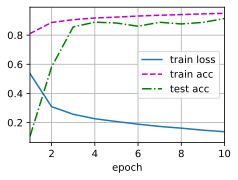

In [ ]:
lr, num_epochs, batch_size = None, None , None
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Tóm tắt

* Về mặt kết nối xuyên tầng, không giống như trong ResNet khi đầu vào và đầu ra được cộng lại với nhau, DenseNet nối các đầu vào và đầu ra theo chiều kênh.

* Các thành phần chính tạo nên DenseNet là các khối dày đặc và các tầng chuyển tiếp.

* Ta cần kiểm soát kích thước của các chiều khi thiết kế mạng bằng cách thêm các tầng chuyển tiếp để làm giảm số lượng kênh.



[Discussions](https://discuss.d2l.ai/t/331)
